## BioGRID Ineraction Sevice

### Protein, Genetic and Chemical Interactions
- Site URL:  https://thebiogrid.org/
- API docs:  https://wiki.thebiogrid.org/doku.php/biogridrest
- API base url:  https://webservice.thebiogrid.org
- API key:  https://webservice.thebiogrid.org

In [1]:
# Import necessary libraries
import os
from dotenv import load_dotenv
import requests
from pprint import pprint

# Load environment variables from .env file
load_dotenv()

# Fetch the API keys and base URLs from the .env file
BG_INT_ACCESS_KEY = os.getenv("BG_INT_ACCESS_KEY")
BG_INT_BASE_URL = os.getenv("BG_INT_BASE_URL")

# Validate the environment variables
if not BG_INT_ACCESS_KEY or not BG_INT_BASE_URL:
    raise ValueError("BG_INT_ACCESS_KEY or BG_INT_BASE_URL is missing from the .env file.")

In [2]:
from pathlib import Path

# Define configuration constants
INTERIM_DIR = Path("../data/interim")  # Standardize path using pathlib

### Table of Contents:
1. **Setup and Configuration**
2. **Helper Functions**
3. **API Query Class**
4. **Data Processing and Visualization**
5. **Network Analysis**
6. **Main Workflow**
7. **Utilities for Robust Querying**

In [11]:
### 1. **Setup and Configuration**

# %% [markdown]
# ## BioGRID Interaction Service
# - **URL**: https://thebiogrid.org/
# - **API Docs**: https://wiki.thebiogrid.org/doku.php/biogridrest
# - **API Base URL**: https://webservice.thebiogrid.org

import os
import requests
from pathlib import Path
from dotenv import load_dotenv
from pprint import pprint

# Load environment variables from .env file
load_dotenv()
BG_INT_ACCESS_KEY = os.getenv("BG_INT_ACCESS_KEY")
BG_INT_BASE_URL = os.getenv("BG_INT_BASE_URL")

if not BG_INT_ACCESS_KEY or not BG_INT_BASE_URL:
    raise ValueError("BG_INT_ACCESS_KEY or BG_INT_BASE_URL is missing from the .env file.")

# Define interim directory
INTERIM_DIR = Path("../data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
### 2. **Helper Functions**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json

def validate_biogrid_response(response):
    """Validate the structure of the BioGRID API response."""
    if not isinstance(response, dict):
        raise ValueError("Response is not a valid JSON dictionary.")
    required_keys = ['BIOGRID_INTERACTION_ID', 'ENTREZ_GENE_A', 'ENTREZ_GENE_B']
    for key in required_keys:
        if key not in response:
            raise ValueError(f"Missing required key: {key}")

def convert_biogrid_json_to_df(json_data):
    """Convert BioGRID JSON data to an optimized pandas DataFrame."""
    # Convert JSON to DataFrame
    df = pd.DataFrame.from_dict(json_data, orient='index')
    
    # Extract publication year from 'PUBMED_AUTHOR'
    df['PUBLICATION_YEAR'] = df['PUBMED_AUTHOR'].str.extract(r'\((\d{4})\)').astype('Int64')
    
    # Sort and set index
    df = df.sort_values('BIOGRID_INTERACTION_ID').set_index('BIOGRID_INTERACTION_ID')
    return df

def generate_summary_statistics(df):
    """Generate summary statistics for the DataFrame."""
    return {
        'total_interactions': len(df),
        'unique_genes': df['OFFICIAL_SYMBOL_A'].nunique() + df['OFFICIAL_SYMBOL_B'].nunique(),
    }

def plot_data_distribution(df):
    """Plot distributions of key columns."""
    if 'PUBLICATION_YEAR' in df.columns and not df['PUBLICATION_YEAR'].isnull().all():
        sns.histplot(df['PUBLICATION_YEAR'].dropna(), kde=True)
        plt.title('Publication Year Distribution')
        plt.xlabel('Publication Year')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No publication year data available for plotting.")

In [13]:
### 3. **API Query Class**

class BioGRIDQuery:
    def __init__(self):
        self.access_key = BG_INT_ACCESS_KEY
        self.base_url = BG_INT_BASE_URL

    def query_interactions(self, **params):
        """Query the BioGRID API."""
        response = requests.get(f"{self.base_url}/interactions/", params=params)
        response.raise_for_status()
        return response.json()

    def save_response(self, data, file_name):
        """Save JSON response to a file."""
        file_path = INTERIM_DIR / file_name
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)
        print(f"Saved to {file_path}")

In [14]:
### 4. **Data Processing and Visualization**

def create_networkx_graph(df):
    """Create a NetworkX graph from the DataFrame."""
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_node(row['OFFICIAL_SYMBOL_A'], entrez_id=row['ENTREZ_GENE_A'])
        G.add_node(row['OFFICIAL_SYMBOL_B'], entrez_id=row['ENTREZ_GENE_B'])
        G.add_edge(row['OFFICIAL_SYMBOL_A'], row['OFFICIAL_SYMBOL_B'])
    return G

def analyze_networkx_graph(G):
    """Analyze and visualize the NetworkX graph."""
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    degree_values = dict(G.degree()).values()
    sns.histplot(degree_values, kde=True)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

In [26]:
### 5. **Main Workflow**

# Initialize the BioGRIDQuery class
biogrid_query = BioGRIDQuery()

# PMID(s) to search for (pipe-separated for multiple genes)
pubmed_article = "35559673"

# Evidence types to include in the response (pipe-separated for multiple types)
evidence_list = "synthetic lethality|negative genetic"

params = {
    "taxId": "9606",  # Human tax ID
    "pubmedList": pubmed_article, # pubmed article ID(s)
    "includeInteractors": "true",
    "evidenceList": evidence_list,
    "includeEvidence": "true",
    "format": "json",
    "accesskey": biogrid_query.access_key
}
response = biogrid_query.query_interactions(**params)
biogrid_query.save_response(response, f"pmid_{pubmed_article}_interactions.json")

Saved to ../data/interim/pmid_35559673_interactions.json


In [28]:
print(f"RESPONSE: type: {type(response)}, length: {len(response)}")

RESPONSE: type: <class 'dict'>, length: 475


Summary Statistics: {'total_interactions': 475, 'unique_genes': 360}


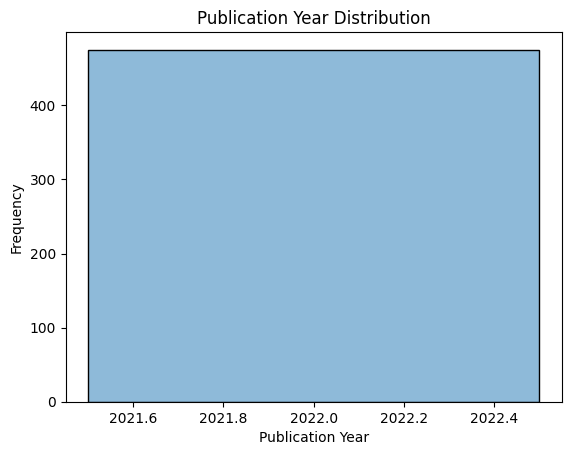

In [30]:
# Convert to DataFrame and perform EDA
df = convert_biogrid_json_to_df(response)
stats = generate_summary_statistics(df)
print("Summary Statistics:", stats)
plot_data_distribution(df)

Nodes: 359, Edges: 475


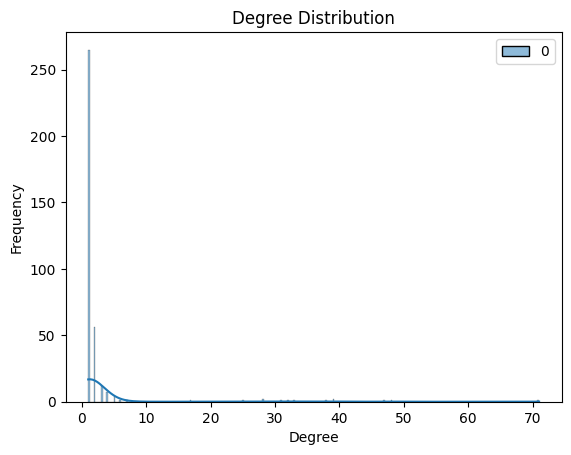

In [31]:
# Create and analyze the graph
G = create_networkx_graph(df)
analyze_networkx_graph(G)